In [2]:
import numpy as np

In [204]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import cv2
import torch
import torchvision.transforms as T
from PIL import Image
import plotly

In [114]:
focal_length = 30 #milimeters
depth_image0 = cv2.imread('ML1/jj/name0-dpt_beit_large_512.pfm', cv2.IMREAD_UNCHANGED)

In [341]:
depth_image0 = cv2.imread('nerf_vis/name0-dpt_beit_large_512.pfm', cv2.IMREAD_UNCHANGED)
depth_image1 = cv2.imread('nerf_vis/name1-dpt_beit_large_512.pfm', cv2.IMREAD_UNCHANGED)
depth_image2 = cv2.imread('nerf_vis/name2-dpt_beit_large_512.pfm', cv2.IMREAD_UNCHANGED)
depth_image3 = cv2.imread('nerf_vis/name3-dpt_beit_large_512.pfm', cv2.IMREAD_UNCHANGED)
# depth_image4 = cv2.imread('name4-dpt_beit_large_512.pfm', cv2.IMREAD_UNCHANGED)
# depth_image5 = cv2.imread('name5-dpt_beit_large_512.pfm', cv2.IMREAD_UNCHANGED)
# depth_image6 = cv2.imread('name6-dpt_beit_large_512.pfm', cv2.IMREAD_UNCHANGED)

friends = cv2.imread('photo_2023-05-10 03.03.28-dpt_beit_large_512.pfm', cv2.IMREAD_UNCHANGED)

# print properties:
print(f"Image resolution: {depth_image0.shape}")
print(f"Data type: {depth_image0.dtype}")
print(f"Min value: {np.min(depth_image0)}")
print(f"Max value: {np.max(depth_image0)}")

Image resolution: (352, 282)
Data type: float32
Min value: 8.582262992858887
Max value: 9389.8623046875


In [459]:
to_tensor = T.ToTensor()
resize = T.Resize((352, 282))

In [166]:
pic = Image.open(f"embeddings/0043_img.png")
pic = resize(pic)
pic = to_tensor(pic)
pic = pic.unsqueeze(0)

In [440]:
model = torch.hub.load("intel-isl/MiDaS", "DPT_Large")

Using cache found in /Users/pe4enkaz/.cache/torch/hub/intel-isl_MiDaS_master


In [465]:
depth = []
resized = []
for i in range(6):
    pic = Image.open(f"musicman/frame_{i}_delay-0.13s.png").convert("RGB")
    pic = resize(pic)
    pic = to_tensor(pic)
    pic = pic.unsqueeze(0)
    resized.append(pic)


batch = torch.concat(resized, dim=0)
with torch.no_grad():
    prediction = model(batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=batch[0].shape[1:],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    output = prediction.cpu().numpy()



In [487]:
for i in range(6):
    pic = Image.open(f"musicman/frame_{i}_delay-0.13s.png").convert("RGB")
    pic = resize(pic)
    pic.save(f"musicman/frame_{i}_delay-0.13s.png")

In [488]:
for i in range(6):
    np.savez(f"depth_{i}.npz", pred=output[i])

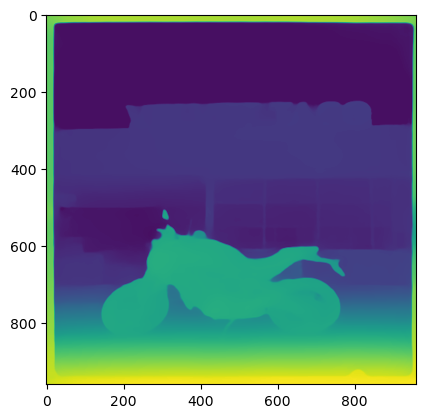

In [9]:
plt.imshow(depth_image0)

In [342]:
depth = [depth_image0, depth_image1, depth_image2, depth_image3]

(array([269158., 312825.,  18615.,  13246.,  16680.,  80708.,  78013.,
         47410.,  54649.,  30296.]),
 array([-391.40506,  527.06525, 1445.5355 , 2364.0059 , 3282.476  ,
        4200.9463 , 5119.4165 , 6037.887  , 6956.3574 , 7874.8276 ,
        8793.298  ], dtype=float32),
 <BarContainer object of 10 artists>)

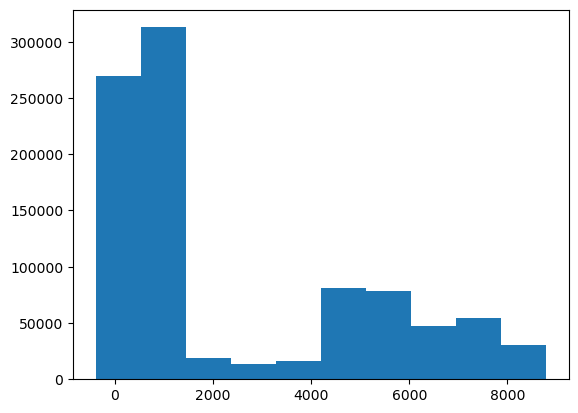

In [11]:
plt.hist(depth_image0.flatten())

In [180]:
f_x = 352 / (352 / (2*30) / (1 + np.sqrt(1 + (352**2) / (2 * 30)**2 )))
f_y = 282 / (282 / (2*30) / (1 + np.sqrt(1 + (282**2) / (2 * 30)**2 )))

In [182]:
f_x, f_y

(417.077022503549, 348.3123306416151)

In [621]:
depth_nerf = np.load("nerf_vis/0.npy")
depth_midas = cv2.imread("nerf_vis/name0-dpt_beit_large_512.pfm", cv2.IMREAD_UNCHANGED)
image = cv2.imread("nerf_vis/000.png")

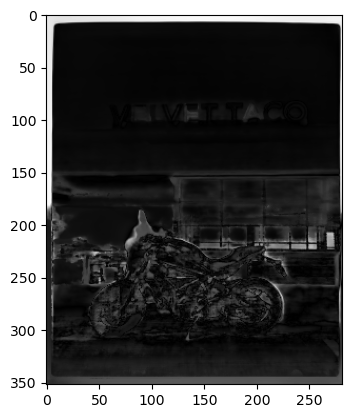

In [858]:
plt.imshow(abs(a_0.detach().numpy() * depth_nerf - depth_midas), cmap="gray")

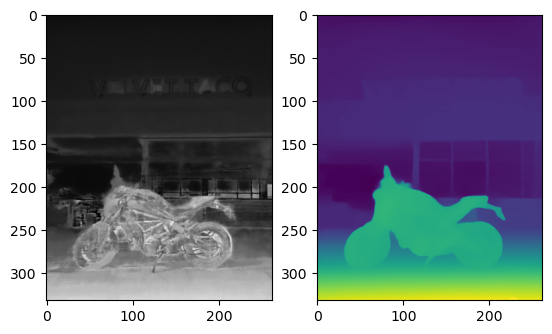

In [561]:
# Read the rgb image:

# Display depth and grayscale image:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(depth_nerf, cmap="gray")
axs[1].imshow(depth_midas)
plt.show()

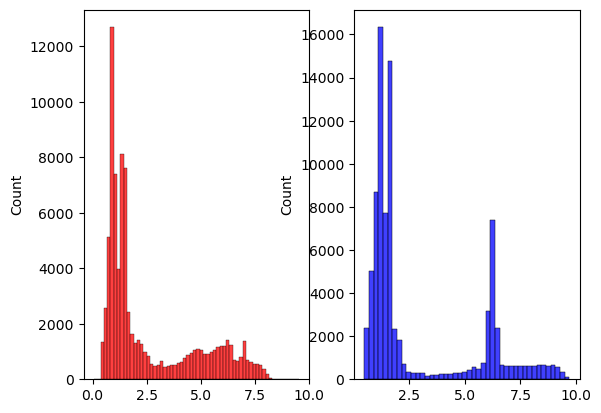

In [587]:
import seaborn as sns

fig, axs = plt.subplots(1, 2)
sns.histplot(depth_nerf.flatten(), color="red", ax=axs[0])
sns.histplot(0.001 * depth_midas.flatten() + 0.5, color="blue", ax=axs[1])

plt.show()

In [480]:
from tqdm.notebook import tqdm
def comp_closest_pts_idx_with_split(pts_src, pts_des):
    """
    :param pts_src:     (3, S)
    :param pts_des:     (3, D)
    :param num_split:
    :return:
    """
    pts_src_list = torch.split(pts_src, 1, dim=1)
    idx_list = []
    for pts_src_sec in pts_src_list:
        diff = pts_src_sec[:, :, np.newaxis] - pts_des[:, np.newaxis, :]  # (3, S, 1) - (3, 1, D) -> (3, S, D)
        dist = torch.linalg.norm(diff, dim=0)  # (S, D)
        closest_idx = torch.argmin(dist, dim=1)  # (S,)
        idx_list.append(closest_idx)
    closest_idx = torch.cat(idx_list)
    return closest_idx

def comp_point_point_error(Xt, Yt):
    closest_idx = comp_closest_pts_idx_with_split(Xt, Yt)
    pt_pt_vec = Xt - Yt[:, closest_idx]  # (3, S) - (3, S) -> (3, S)
    pt_pt_dist = torch.linalg.norm(pt_pt_vec, dim=0)
    eng = torch.mean(pt_pt_dist)
    return eng

def get_pc_loss(Xt, Yt):
    # compute  error
    loss1 = comp_point_point_error(Xt.permute(1, 0), Yt.permute(1, 0))
    loss2 = comp_point_point_error(Yt.permute(1, 0), Xt.permute(1, 0))
    loss  = loss1 + loss2
    return loss
camera_coordinates = (176, 282, 30)

In [481]:
def convert_from_uvd(d, a = 0, b = 0, is_nerf = None):
    jj = np.tile(range(d.shape[1]), d.shape[0])
    ii = np.repeat(range(d.shape[0]), d.shape[1])
    jj = torch.from_numpy(jj)
    ii = torch.from_numpy(ii)
    camera_coordinates = (176, 282, 30)
    if is_nerf is not None:
        d = 1/(a + b * d)

    x_over_z = -(camera_coordinates[0] - jj) / f_x
    y_over_z = -(camera_coordinates[1] - ii) / f_y
    

    z = d.max() - d.flatten() / np.sqrt(1. + x_over_z**2 + y_over_z**2)
    x = x_over_z * z #ort / proj = tan(smth)
    y = y_over_z * z 
    return x, y, z

In [623]:
ans_nerf = convert_from_uvd(depth_nerf, is_nerf=None)
ans_midas = convert_from_uvd(depth_midas, is_nerf = None)

In [179]:
# import optuna

# class Objective:
#     def __init__(self, d_1, d_2):
#         self.d_1 = d_1
#         self.d_2 = d_2
#     def __call__(self, trial):
#         a = trial.suggest_float("a", -100, 100)
#         b = trial.suggest_float("b", -100, 100)
#         pcd_1 = convert_from_uvd(self.d_1, is_nerf=None)
#         pcd_2 = convert_from_uvd(self.d_2, a, b)
        
#         pcd_flat = np.concatenate([pcd_1[0].reshape(-1, 1),
#                                    pcd_1[1].reshape(-1, 1),
#                                    pcd_1[2].reshape(-1, 1)],
#                                   axis=1)
#         pcd_flat = pcd_flat[np.random.choice(pcd_flat.shape[0], size=1000), :]
#         pcd_nerf = torch.from_numpy(pcd_flat)
        
        
#         pcd_flat = np.concatenate([pcd_2[0].reshape(-1, 1),
#                                    pcd_2[1].reshape(-1, 1),
#                                    pcd_2[2].reshape(-1, 1)],
#                                   axis=1)
#         pcd_flat = pcd_flat[np.random.choice(pcd_flat.shape[0], size=1000), :]
#         pcd_midas = torch.from_numpy(pcd_flat)
        
        
        
#         return get_pc_loss(1000*pcd_nerf, pcd_midas)

# study = optuna.create_study(direction="minimize")
# study.optimize(Objective(depth_nerf, depth_midas[20:, 5:-20]), n_trials=100, show_progress_bar=True)

In [624]:
test_nerf = np.concatenate([ans_nerf[0].reshape(-1, 1), ans_nerf[1].reshape(-1, 1), ans_nerf[2].reshape(-1, 1)], axis=1)
test_midas = np.concatenate([ans_midas[0].reshape(-1, 1), ans_midas[1].reshape(-1, 1), ans_midas[2].reshape(-1, 1)], axis=1)

In [534]:
pcd_midas = []
for i in range(4):
    ans_midas_ = convert_from_uvd(output[i], is_nerf = None)
    test_midas_ = np.concatenate([ans_midas_[0].reshape(-1, 1),
                                  ans_midas_[1].reshape(-1, 1),
                                  ans_midas_[2].reshape(-1, 1)],
                                 axis=1)
    pcd_midas.append(test_midas_)

In [529]:
len(pcd_midas)

4

In [716]:
a = test_nerf[np.random.choice(test_nerf.shape[0], size=5000), :]
b = test_midas[np.random.choice(test_midas.shape[0], size=5000), :]
diff = a[:, None] - b[None]
dists = np.linalg.norm(diff, axis=-1)

a_to_b = np.min(dists, axis=-1)
b_to_a = np.min(dists, axis=-2)
d_q = np.quantile(np.concatenate([a_to_b, b_to_a]), q=0.70)

distant_a_to_b = a_to_b > d_q
distant_b_to_a = b_to_a > d_q

a_subset = a[distant_a_to_b]
b_subset = b[distant_b_to_a]
distant_points = np.concatenate([a_subset, b_subset], axis=0)

In [717]:
distant_points.shape

(3000, 3)

In [704]:
np.percentile(dists, q)

array([[8777.783 , 3889.2197, 2199.8281, ..., 3732.1824, 8204.048 ,
        8705.325 ],
       [8777.999 , 3889.4382, 2200.0452, ..., 3732.3945, 8204.292 ,
        8705.603 ],
       [8782.299 , 3893.6704, 2204.2014, ..., 3736.5872, 8208.562 ,
        8709.868 ],
       ...,
       [8777.224 , 3888.743 , 2199.403 , ..., 3731.7266, 8203.568 ,
        8704.871 ],
       [8780.657 , 3892.0327, 2202.5796, ..., 3734.955 , 8206.93  ,
        8708.256 ],
       [8782.212 , 3893.5818, 2204.1123, ..., 3736.4983, 8208.473 ,
        8709.778 ]], dtype=float32)

In [679]:
dist

array([[ 13817.585,  31373.299, 221936.58 ],
       [ 13810.366,  31360.355, 221953.03 ],
       [ 13901.77 ,  31538.893, 221732.25 ]], dtype=float32)

In [310]:
pc_losses = [7731.9553]


In [718]:
pcd_o3d_1 = o3d.geometry.PointCloud() 
# test_midas[:, 2] *= 0.5
# # test_midas[:, 1] -= 100
# test_nerf[:, 2] *= 0.5
pcd_o3d_1.points = o3d.utility.Vector3dVector(distant_points)

# pcd_o3d_1.paint_uniform_color(np.array([1, 0, 0]))


# pcd_o3d_2 = o3d.geometry.PointCloud()  
# # test_nerf[:, 2] *= 0.5
# pcd_o3d_2.points = o3d.utility.Vector3dVector(nofm)
# pcd_o3d_2.paint_uniform_color(np.array([0, 0, 1]))

# pcd = []
# for i in range(4):
#     pcd_o3d = o3d.geometry.PointCloud() 
#     pcd_o3d.points = o3d.utility.Vector3dVector(pcd_midas[i])
#     # pcd_o3d.paint_uniform_color(np.array([1, 0, 1]))
#     pcd.append(pcd_o3d)

o3d.visualization.draw_geometries([pcd_o3d_1])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [848]:
loss = pd.read_csv("loss_pc.csv")
L2mean = pd.read_csv("loss_mean_l2.csv")
loss_depth = pd.read_csv("loss_rgb.csv")
PSNR = pd.read_csv("PSNR.csv").rename(columns={"Value" : "PSNR"})

In [849]:
data = pd.DataFrame(columns={"PCD-Loss", "L2-mean", "Loss Depth"})
data["PCD-Loss"] = loss.Value
data["L2-mean"] = L2mean.Value
data["Loss Depth"] = loss_depth.Value


In [850]:
lst = list(PSNR.PSNR)

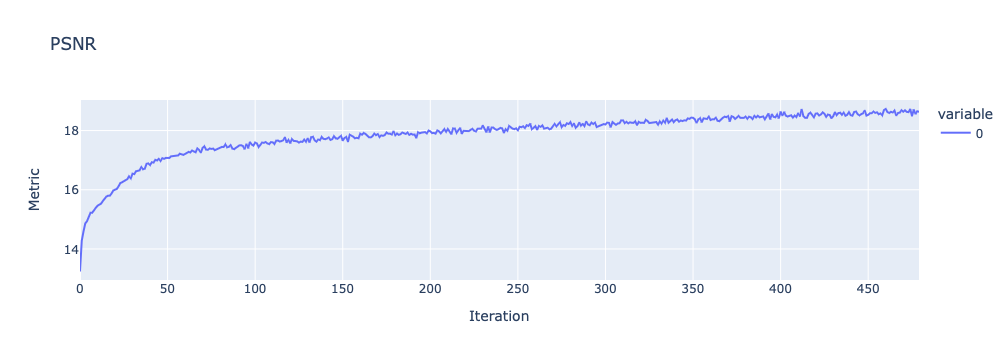

In [852]:
import plotly.express as px

fig = px.line(lst, title='PSNR', labels={"value": "Metric", "index" : "Iteration"})
fig.show()

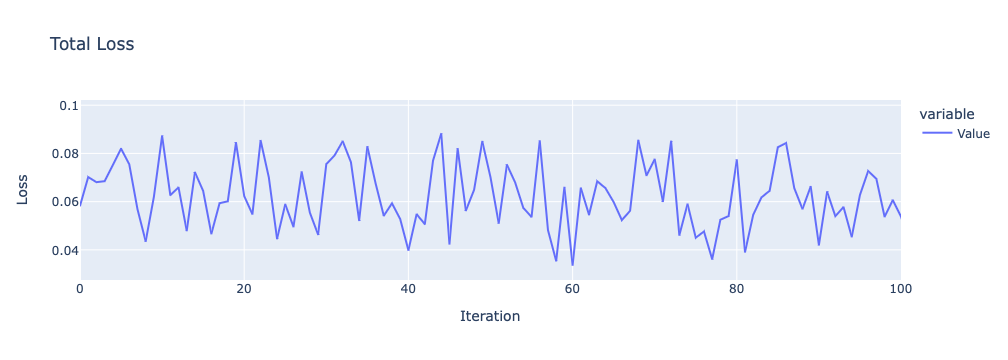

In [777]:
import plotly.express as px

fig = px.line(L2mean.Value, title='Total Loss', labels={"value": "Loss", "index" : "Iteration"})
fig.update_xaxes(range=[0, 100])
fig.show()

In [392]:
# import torch.nn as nn
# import torch
# def jopa(d):
#     jj = np.tile(range(d.shape[1]), d.shape[0])
#     ii = np.repeat(range(d.shape[0]), d.shape[1])
#     jj = torch.from_numpy(jj)
#     ii = torch.from_numpy(ii)
#     d = 1/(1.1778 + 4.6837 * d)

#     x_over_z = -(176 - jj) / 1460.959900068132
#     y_over_z = -(282 - ii) / 1181.1979454462357


#     z = d.max() - d.flatten() / np.sqrt(1. + x_over_z**2 + y_over_z**2)
#     x = x_over_z * z #ort / proj = tan(smth)
#     y = y_over_z * z 
#     ass = torch.cat([x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)], dim=1)
#     return ass

In [610]:
get_pc_loss(torch.from_numpy(test_midas[np.random.choice(test_midas.shape[0], size=1000), :]),
            torch.from_numpy(test_nerf[np.random.choice(test_nerf.shape[0], size=1000), :]))

tensor(279.9641)

In [615]:
class ABOpt(nn.Module):
    def __init__(self, a_0, ref):
        super().__init__()
        self.a_0 = nn.Parameter(torch.tensor([a_0]))
        self.y = torch.from_numpy(ref)
        
    def forward(self, x):
        loss = get_pc_loss(self.a_0 * x, self.y)
        mse_loss = torch.mean(self.a_0 * x - self.y)
        return loss, mse_loss 

    
def train(opt, model, n, x):
    losses = []
    mse_l = []
    x = torch.from_numpy(x)
    for i in tqdm(range(n), desc="Training"):
        loss, mse = model(x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        if i % 50 == 0:
            print(loss)
        losses.append(100*loss.item())
        mse_l.append(100*mse.item())        
    return model.a_0, losses, mse_l 
    
        
model = ABOpt(1000., test_midas[np.random.choice(test_midas.shape[0], size=1000), :])

opt = torch.optim.Adam([model.a_0], lr=1)

a_0, loss, mse = train(opt, model, 100, test_nerf[np.random.choice(test_nerf.shape[0], size=1000), :])

Training:   0%|          | 0/100 [00:00<?, ?it/s]

tensor(289.1794, grad_fn=<AddBackward0>)
tensor(275.2205, grad_fn=<AddBackward0>)


In [616]:
model = ABOpt(1000., test_midas[np.random.choice(test_midas.shape[0], size=1000), :])

opt = torch.optim.Adam([model.a_0], lr=1)
a_0, loss_1, mse_1 = train(opt, model, 50, test_nerf[np.random.choice(test_nerf.shape[0], size=1000), :])

model = ABOpt(1000., test_midas[np.random.choice(test_midas.shape[0], size=1000), :])

opt = torch.optim.Adam([model.a_0], lr=1)
a_0, loss_2, mse_2 = train(opt, model, 100, test_nerf[np.random.choice(test_nerf.shape[0], size=1000), :])
model = ABOpt(1000., test_midas[np.random.choice(test_midas.shape[0], size=1000), :])

opt = torch.optim.Adam([model.a_0], lr=1)
a_0, loss_3, mse_3 = train(opt, model, 500, test_nerf[np.random.choice(test_nerf.shape[0], size=1000), :])
model = ABOpt(1000., test_midas[np.random.choice(test_midas.shape[0], size=1000), :])

opt = torch.optim.Adam([model.a_0], lr=1)
a_0, loss_4, mse_4 = train(opt, model, 1000, test_nerf[np.random.choice(test_nerf.shape[0], size=1000), :])

Training:   0%|          | 0/50 [00:00<?, ?it/s]

tensor(268.5384, grad_fn=<AddBackward0>)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

tensor(266.4565, grad_fn=<AddBackward0>)
tensor(249.5665, grad_fn=<AddBackward0>)


Training:   0%|          | 0/500 [00:00<?, ?it/s]

tensor(282.5762, grad_fn=<AddBackward0>)
tensor(267.9366, grad_fn=<AddBackward0>)
tensor(267.8889, grad_fn=<AddBackward0>)
tensor(267.8888, grad_fn=<AddBackward0>)
tensor(267.8888, grad_fn=<AddBackward0>)
tensor(267.8888, grad_fn=<AddBackward0>)
tensor(267.8888, grad_fn=<AddBackward0>)
tensor(267.8888, grad_fn=<AddBackward0>)
tensor(267.8888, grad_fn=<AddBackward0>)
tensor(267.8888, grad_fn=<AddBackward0>)


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor(267.2631, grad_fn=<AddBackward0>)
tensor(257.9841, grad_fn=<AddBackward0>)
tensor(257.9643, grad_fn=<AddBackward0>)
tensor(257.9641, grad_fn=<AddBackward0>)
tensor(257.9641, grad_fn=<AddBackward0>)
tensor(257.9640, grad_fn=<AddBackward0>)
tensor(257.9640, grad_fn=<AddBackward0>)
tensor(257.9640, grad_fn=<AddBackward0>)
tensor(257.9640, grad_fn=<AddBackward0>)
tensor(257.9640, grad_fn=<AddBackward0>)
tensor(257.9640, grad_fn=<AddBackward0>)
tensor(257.9640, grad_fn=<AddBackward0>)
tensor(257.9640, grad_fn=<AddBackward0>)
tensor(257.9641, grad_fn=<AddBackward0>)
tensor(257.9640, grad_fn=<AddBackward0>)
tensor(257.9641, grad_fn=<AddBackward0>)
tensor(257.9640, grad_fn=<AddBackward0>)
tensor(257.9641, grad_fn=<AddBackward0>)
tensor(257.9641, grad_fn=<AddBackward0>)
tensor(257.9640, grad_fn=<AddBackward0>)


In [552]:
import pandas as pd
df = pd.DataFrame(columns = {"50 Iterations", "100 Iterations", "500 Iterations", "1000 Iterations"})
df["50 Iterations"] = loss_1 + [np.NaN] * (1000 - 50)
df["100 Iterations"] = loss_2 + [np.NaN] * (1000 - 100)
df["500 Iterations"] = loss_3  + [np.NaN] * (1000 - 500)
df["1000 Iterations"] = loss_4



df_mean = pd.DataFrame(columns = {"50 Iterations", "100 Iterations", "500 Iterations", "1000 Iterations"})
df_mean["50 Iterations"] = mse_1 + [np.NaN] * (1000 - 50)
df_mean["100 Iterations"] = mse_2 + [np.NaN] * (1000 - 100)
df_mean["500 Iterations"] = mse_3  + [np.NaN] * (1000 - 500)
df_mean["1000 Iterations"] = mse_4

In [553]:
df

,1000 Iterations,50 Iterations,500 Iterations,100 Iterations
0,256.135082,234.489918,243.222141,239.626050
1,216.724110,198.213542,208.367991,197.254455
2,186.741185,170.541131,174.101996,163.954663
3,168.396783,159.601164,156.549716,150.666893
4,173.339546,164.535010,163.639688,158.203530
...,...,...,...,...
995,166.796267,NaN,NaN,NaN
996,166.789794,NaN,NaN,NaN
997,166.795731,NaN,NaN,NaN
998,166.795909,NaN,NaN,NaN


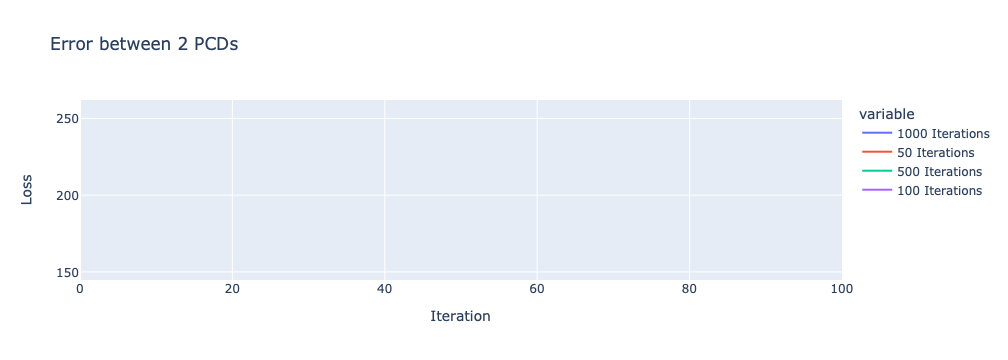

In [554]:
import plotly.express as px

fig = px.line(df, title='Error between 2 PCDs', labels={"value": "Loss", "index" : "Iteration"})
fig.update_xaxes(range=[0, 100])
fig.show()

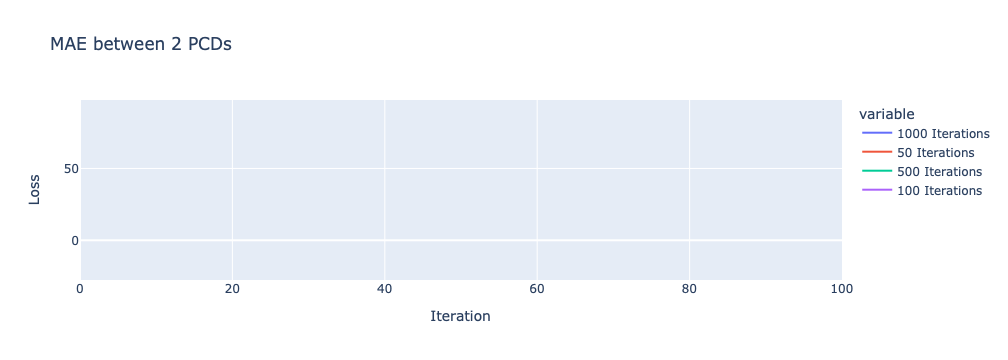

In [555]:
import plotly.express as px

fig = px.line(df_mean, title='MAE between 2 PCDs', labels={"value": "Loss", "index" : "Iteration"})
fig.update_xaxes(range=[0, 100])
fig.show()

In [187]:
f_x = 1408 / (1408/(2*26)/(1 + np.sqrt(1 + (1408**2) /(2 * 26)**2 )))
f_y = 1128 / (1128/(2*26)/(1 + np.sqrt(1 + (1128**2) /(2 * 26)**2 )))

In [77]:
f_x, f_y

(1460.959900068132, 1181.1979454462357)

In [21]:
intr_matrix[0, 0] = f_x
intr_matrix[1, 1] = f_y

In [22]:
intr_matrix

array([[1.46095990e+03, 0.00000000e+00, 7.04000000e+02],
       [0.00000000e+00, 1.18119795e+03, 5.64000000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [103]:
for i in range(7):
    eye = np.eye(3)
    eye = np.vstack((eye, np.zeros((1, 3))))
    eye = np.hstack((eye, np.array([i*1408, 0, 0, 1]).reshape(-1, 1)))
    gt_poses.append(eye[:, :, None])

In [104]:
gt_poses = np.concatenate(gt_poses, axis=2)

In [108]:
gt_poses = np.transpose(gt_poses, (2, 0, 1))

In [110]:
np.savez("gt_poses", poses=gt_poses)

In [391]:
s = np.load("gt_poses.npy")

array([[7.040e+02, 5.640e+02, 3.000e+01, 1.000e+00],
       [2.112e+03, 5.640e+02, 3.000e+01, 1.000e+00],
       [3.520e+03, 5.640e+02, 3.000e+01, 1.000e+00],
       [4.928e+03, 5.640e+02, 3.000e+01, 1.000e+00],
       [6.336e+03, 5.640e+02, 3.000e+01, 1.000e+00],
       [7.744e+03, 5.640e+02, 3.000e+01, 1.000e+00],
       [9.152e+03, 5.640e+02, 3.000e+01, 1.000e+00]])

In [196]:
intr = o3d.camera.PinholeCameraIntrinsic(1128, 1408, fx=f_x, fy=f_y, cx=CX_DEPTH, cy=CY_DEPTH)

In [199]:
intr.intrinsic_matrix

array([[1.46927783e+03, 0.00000000e+00, 7.04000000e+02],
       [0.00000000e+00, 1.18959462e+03, 5.64000000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [256]:
import moviepy.editor as mvp

In [282]:
depth_0 = cv2.imread('nerf_vis/0000_0_img.png', cv2.IMREAD_UNCHANGED)
depth_1 = cv2.imread('nerf_vis/0000_1_img.png', cv2.IMREAD_UNCHANGED)
depth_2 = cv2.imread('nerf_vis/0000_2_img.png', cv2.IMREAD_UNCHANGED)
depth_3 = cv2.imread('nerf_vis/0000_3_img.png', cv2.IMREAD_UNCHANGED)
depth_4 = cv2.imread('nerf_vis/0000_4_img.png', cv2.IMREAD_UNCHANGED)
depth_clip = [depth_0, depth_1, depth_2, depth_3, depth_4]

(352, 282, 1)

In [272]:
# clip = mvp.ImageSequenceClip(['nerf_vis/0000_0_depth.png',
#                               'nerf_vis/0000_1_depth.png', 
#                               'nerf_vis/0000_2_depth.png',
#                               'nerf_vis/0000_3_depth.png', 
#                               'nerf_vis/0000_4_depth.png'], with_mask=False, fps=25)

In [280]:
def npy_to_gif(im_list, filename):

    save_dir = '/nerf_vis'

    # if not os.path.exists(save_dir):
    #     print ('creating directory: ', save_dir)
    #     os.mkdir(save_dir)

    clip = mvp.ImageSequenceClip(im_list, fps=4)
    clip.write_gif(filename + '.gif')
    return

In [283]:
npy_to_gif(depth_clip, "vis_img")

MoviePy - Building file vis_img.gif with imageio.


In [413]:
video_clip = mvp.VideoFileClip("NEW.gif")

In [415]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_h, size_w = video.size
    arr = np.zeros([nframes, size_w, size_h])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

In [430]:
pics = video_to_array(video_clip)


image size: 1251 x 1000, 
number of frames: 15
